In [1]:
import pandas as pd
import praw
from prawcore.exceptions import NotFound
from textblob import TextBlob
import networkx as nx
G = nx.Graph()
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')
import emoji
import demoji
import re
import string
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('wordnet')
import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\swapn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
reddit = praw.Reddit(client_id="UJB8dd4JEV3M405S2NTn1g",  # your client id
                     client_secret="Mc3huEYmHcU6c0HSTOZLefZqLZqHHw",  # your client secret
                     user_agent="EpicGames")  # your user agent

# Get 1000 most recent posts from /r/ActivisionPC
Activision_posts = []
for post in reddit.subreddit('Activision').controversial(limit=1500):
    post_info = {
        'author_name': post.author.name if post.author else '[deleted]',
        'time_posted': pd.Timestamp(post.created_utc, unit='s'),
        'total_comments': post.num_comments,
        'upvotes': post.score,
        'post_title': post.title,
        'post_text': post.selftext,
        'comments': []
    }
    post.comments.replace_more(limit=None)
    for comment in post.comments:
        comment_info = {
            'comment': comment.body,
            'author_name': comment.author.name if comment.author else '[deleted]',
            'subcomments': [],
            'upvotes': comment.score
        }
        for subcomment in comment.replies:
            subcomment_info = {
                'comment': subcomment.body,
                'author_name': subcomment.author.name if subcomment.author else '[deleted]',
                'upvotes': subcomment.score
            }
            comment_info['subcomments'].append(subcomment_info)
        post_info['comments'].append(comment_info)
    Activision_posts.append(post_info)

Activision_DF = pd.DataFrame(Activision_posts, columns=['author_name', 'time_posted', 'total_comments', 'upvotes', 'post_title', 'post_text', 'comments'])
Activision_DF.to_csv('Controsample.csv', index=False)

In [3]:
Activision_DF.head(5)

author_name         time_posted  total_comments  upvotes  \
0           BRALLUS 2019-10-29 19:41:03               1        0   
1         RayShotz_ 2019-09-30 20:48:09              45        0   
2           hari333 2022-11-02 13:49:40              43        3   
3       Snowinater3 2022-12-15 07:56:21              45        3   
4  Mission_Carrot65 2023-04-10 15:38:31              21        0   

                                          post_title  \
0  [MW] This one is for the people complaining ab...   
1  All PC and Xbox users on here complaining abou...   
2                               Ban all PC crossplay   
3  Why are there so many pride flags but not a si...   
4                     Want to help, All COD players.   

                                           post_text  \
0                                                      
1                                                      
2  As a PS5 gamer I feel sorry for the Xbox gamer...   
3                                                      
4  Please read the entire guide. I'm new here to ...   

                                            comments  
0  [{'comment': 'THIS!', 'author_name': 'Ghostdog...  
1  [{'comment': '#youAreToxicAF', 'author_name': ...  
2  [{'comment': 'It’s funny because I play on PC ...  
3  [{'comment': 'bruh having pride flag equipped ...  
4  [{'comment': 'What if you're using a console?'...

In [4]:
len(Activision_DF)

995

In [5]:
unique_users = Activision_DF['author_name'].unique()
num_unique_users = len(unique_users)
print("Number of unique users in all comments:", num_unique_users)

Number of unique users in all comments: 795


In [6]:
# Perform sentiment analysis for all comments
Activision_DF['sentiment_score'] = Activision_DF['comments'].apply(lambda x: sum(TextBlob(comment['comment']).sentiment.polarity for comment in x))
Activision_DF['num_comments'] = Activision_DF['comments'].apply(len)

# Calculate personal sentiment score for each unique user
personal_sentiment_scores = []
for user in unique_users:
    user_comments = Activision_DF[Activision_DF['author_name'] == user]['comments'].values[0]
    if len(user_comments) > 0:
        user_sentiment_score = sum(TextBlob(comment['comment']).sentiment.polarity for comment in user_comments) / len(user_comments)
    else:
        user_sentiment_score = 0
    personal_sentiment_scores.append({'author_name': user, 'personal_sentiment_score': user_sentiment_score})

personal_sentiment_scores_df = pd.DataFrame(personal_sentiment_scores)

# Get top 50 most negative and top 50 most positive users
top_50_negative_users = personal_sentiment_scores_df.nsmallest(50, 'personal_sentiment_score')
top_50_positive_users = personal_sentiment_scores_df.nlargest(50, 'personal_sentiment_score')

In [7]:
personal_sentiment_scores_df.head(5)

author_name  personal_sentiment_score
0           BRALLUS                  0.000000
1         RayShotz_                  0.098517
2           hari333                  0.033747
3       Snowinater3                  0.076069
4  Mission_Carrot65                  0.056726

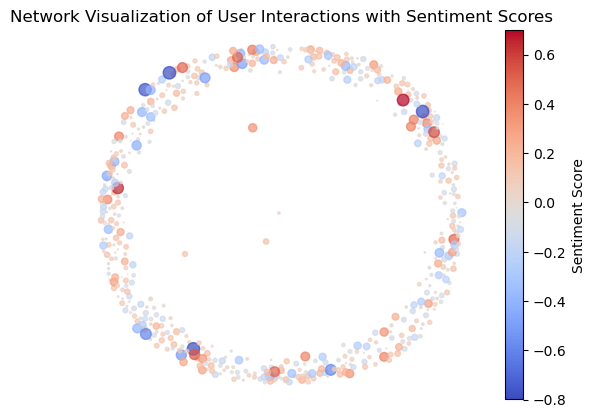

In [8]:
# Add nodes for users
for user in personal_sentiment_scores_df['author_name']:
    G.add_node(user)

# Add edges between users based on interactions (e.g., comments, likes, replies)
# You may need to extract interaction data from your dataset and add edges accordingly

# Set node size and color based on sentiment scores
node_size = personal_sentiment_scores_df['personal_sentiment_score'].abs() * 100  # Use absolute value of sentiment score as node size
node_color = personal_sentiment_scores_df['personal_sentiment_score']

# Draw the network graph
pos = nx.spring_layout(G)  # Layout for positioning nodes
cmap = plt.cm.coolwarm  # Choose a colormap
norm = plt.Normalize(vmin=node_color.min(), vmax=node_color.max())  # Normalize the color scale
node_colors = cmap(norm(node_color))  # Map sentiment scores to colors
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3)
plt.title("Network Visualization of User Interactions with Sentiment Scores")

# Add a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Sentiment Score")
plt.axis('off')
plt.show()

#Larger node size indicates a higher absolute, Smaller node size indicates a lower absolute  value of the sentiment score.

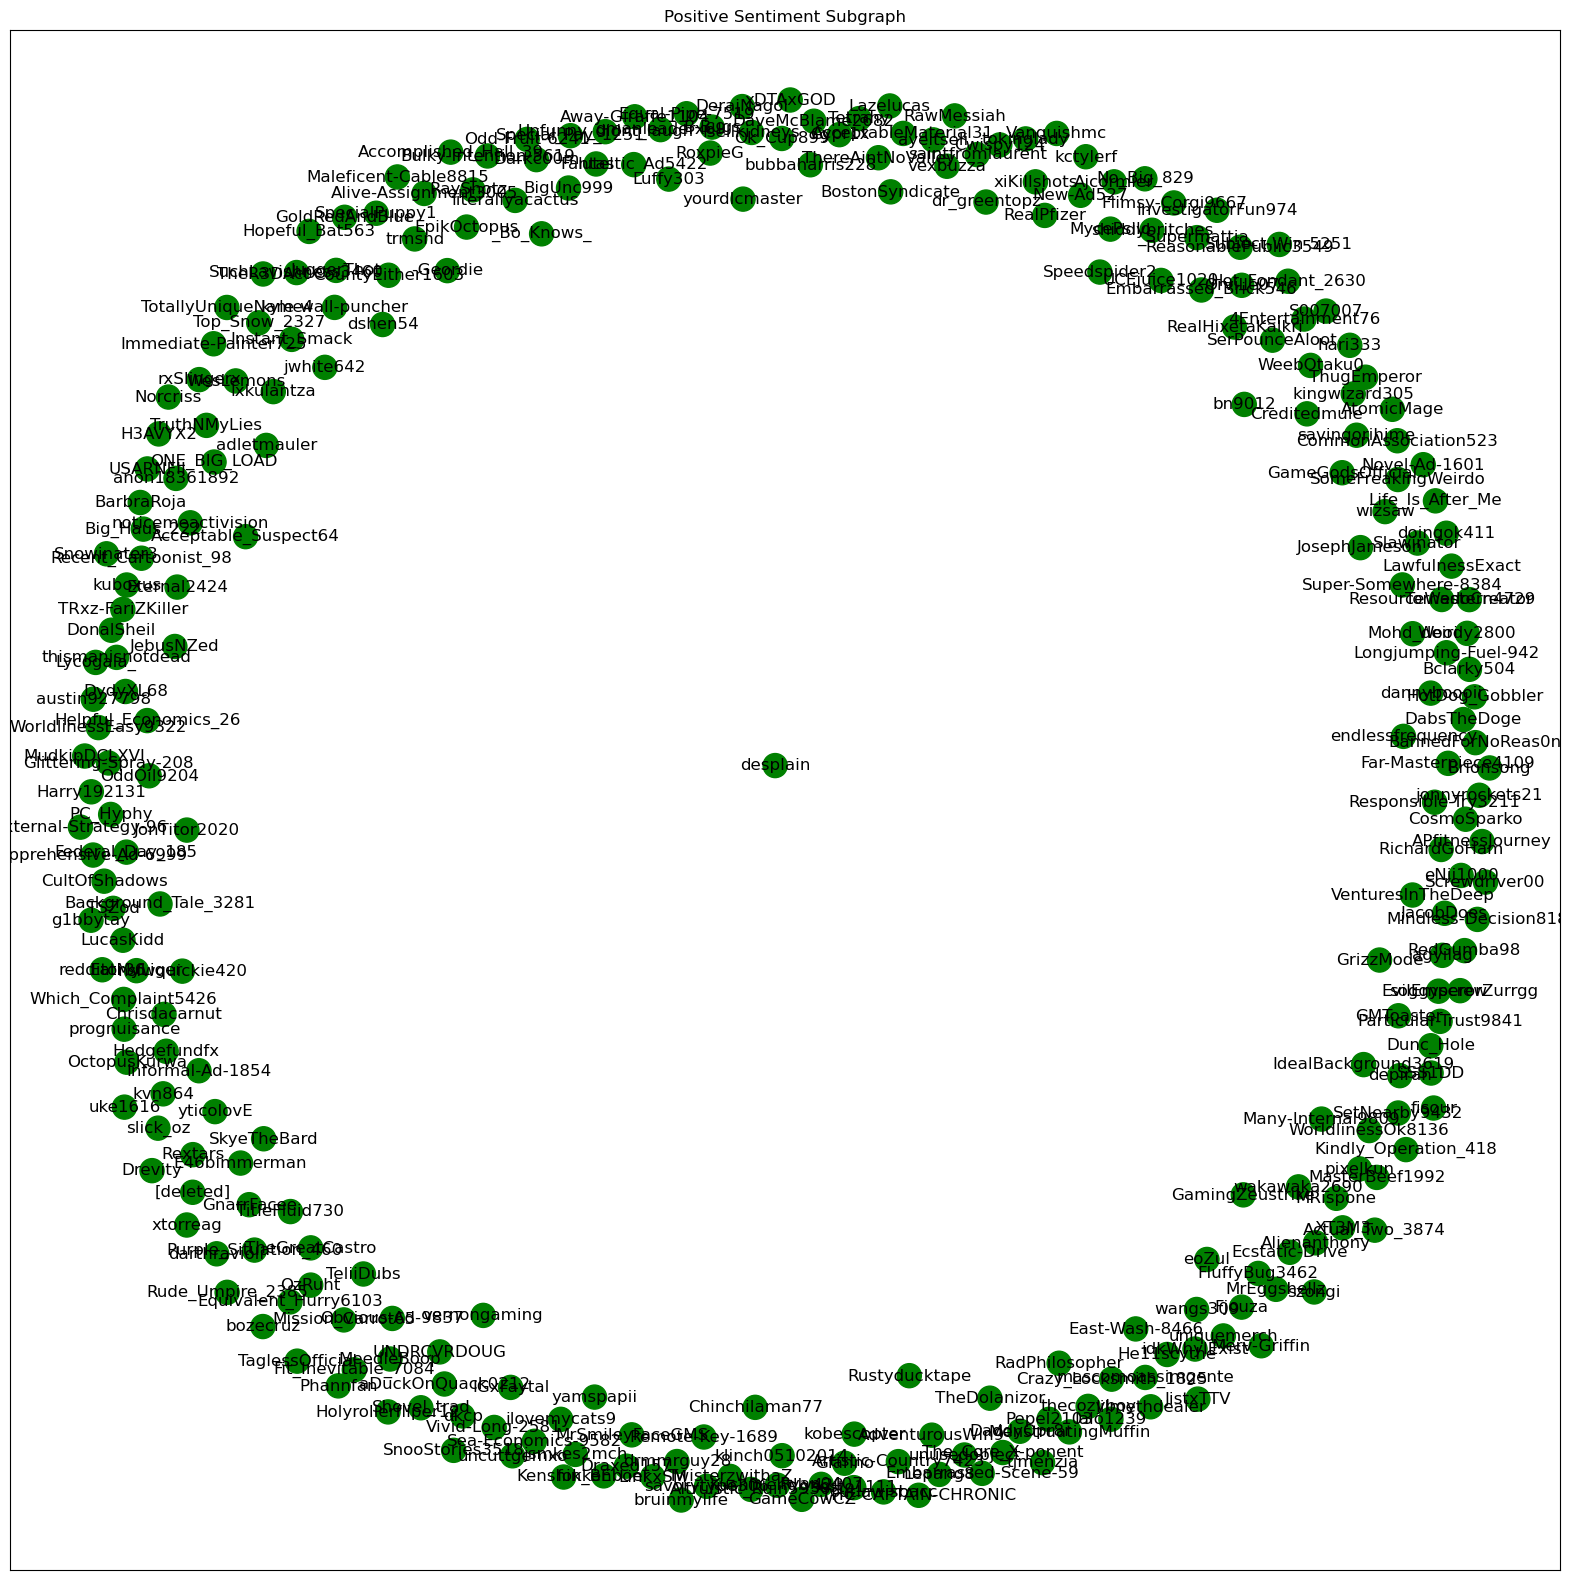

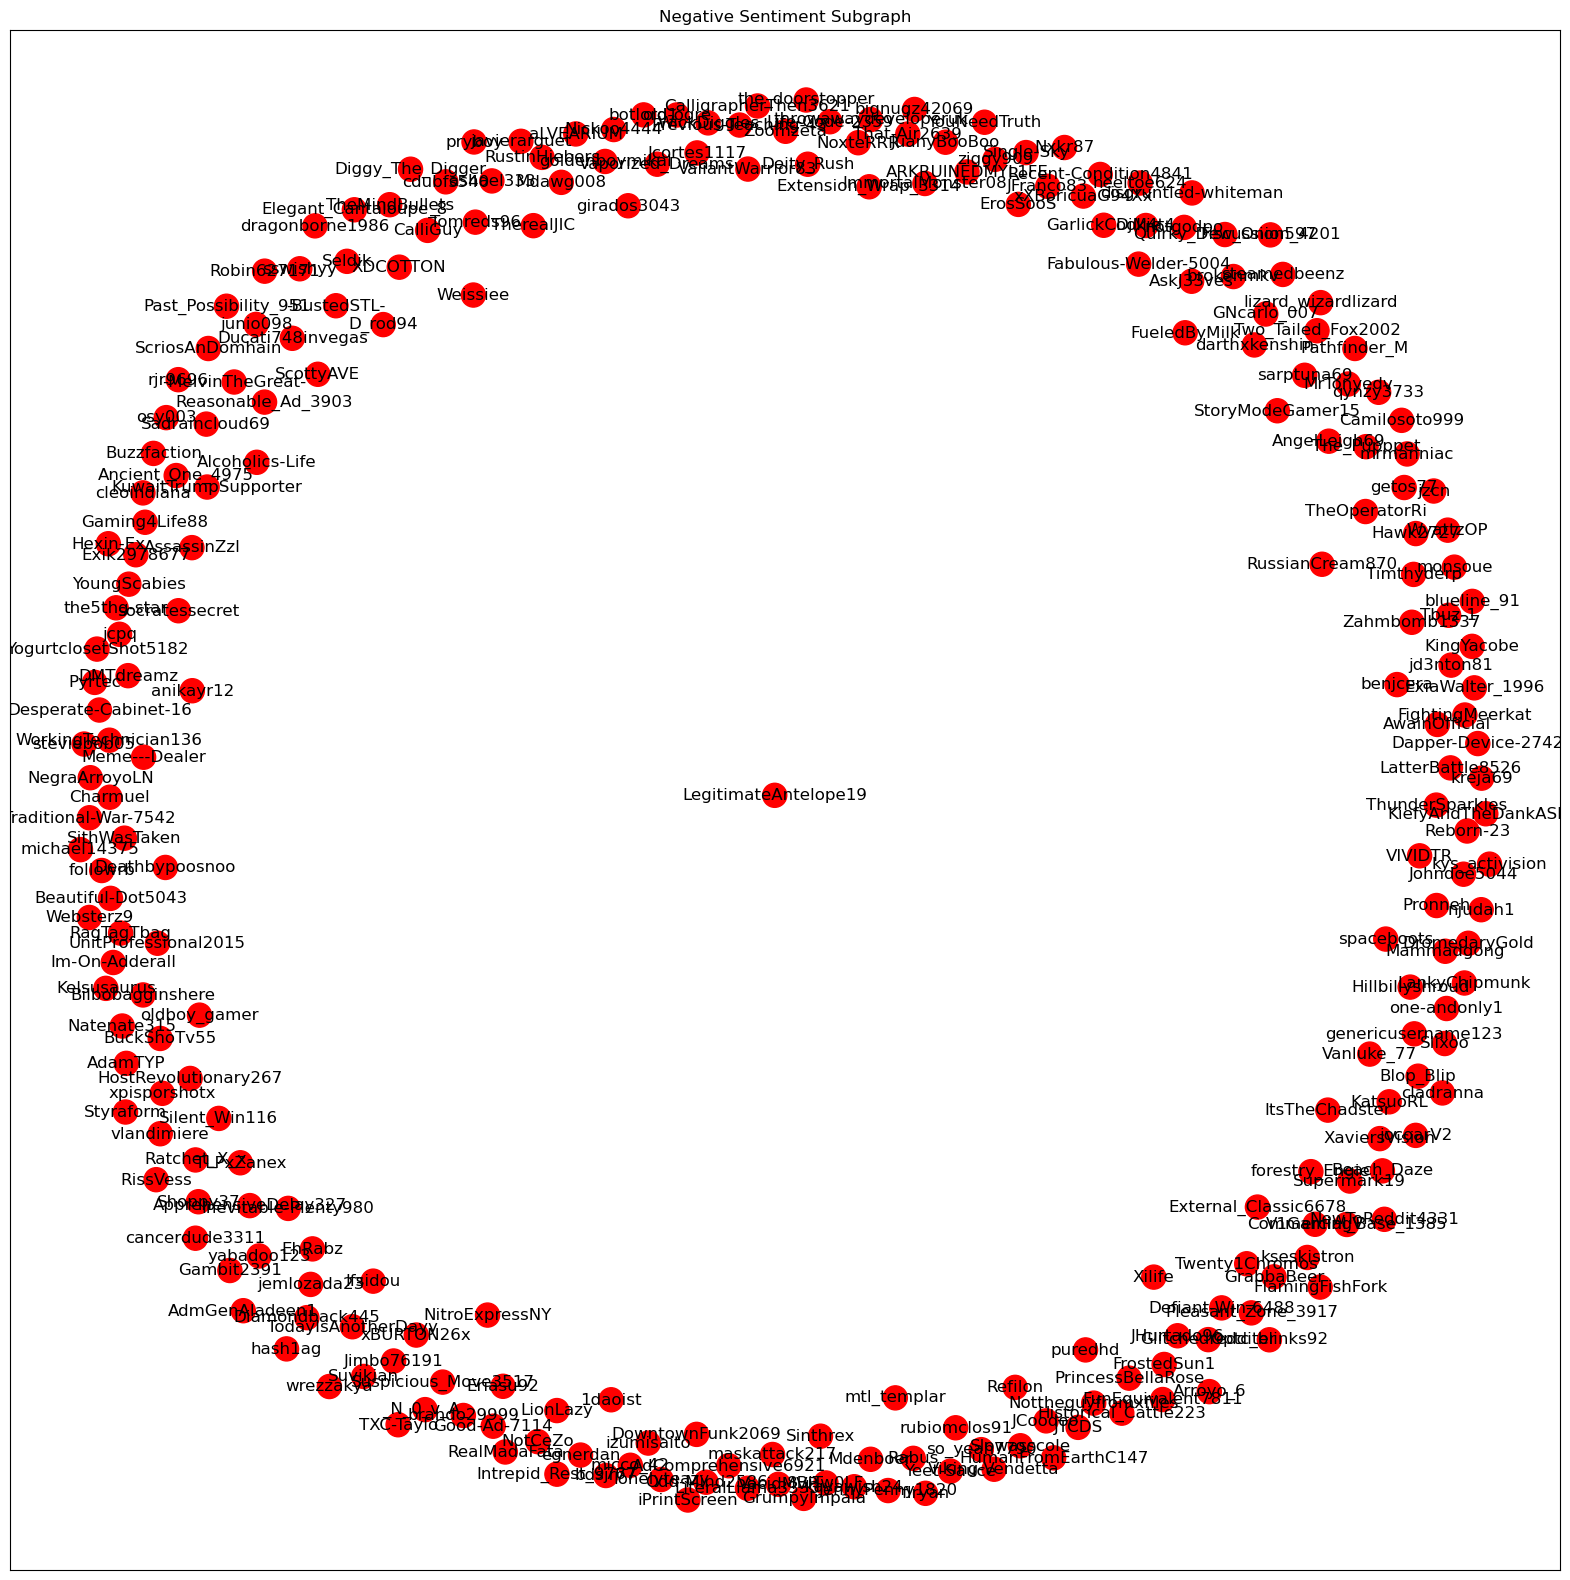

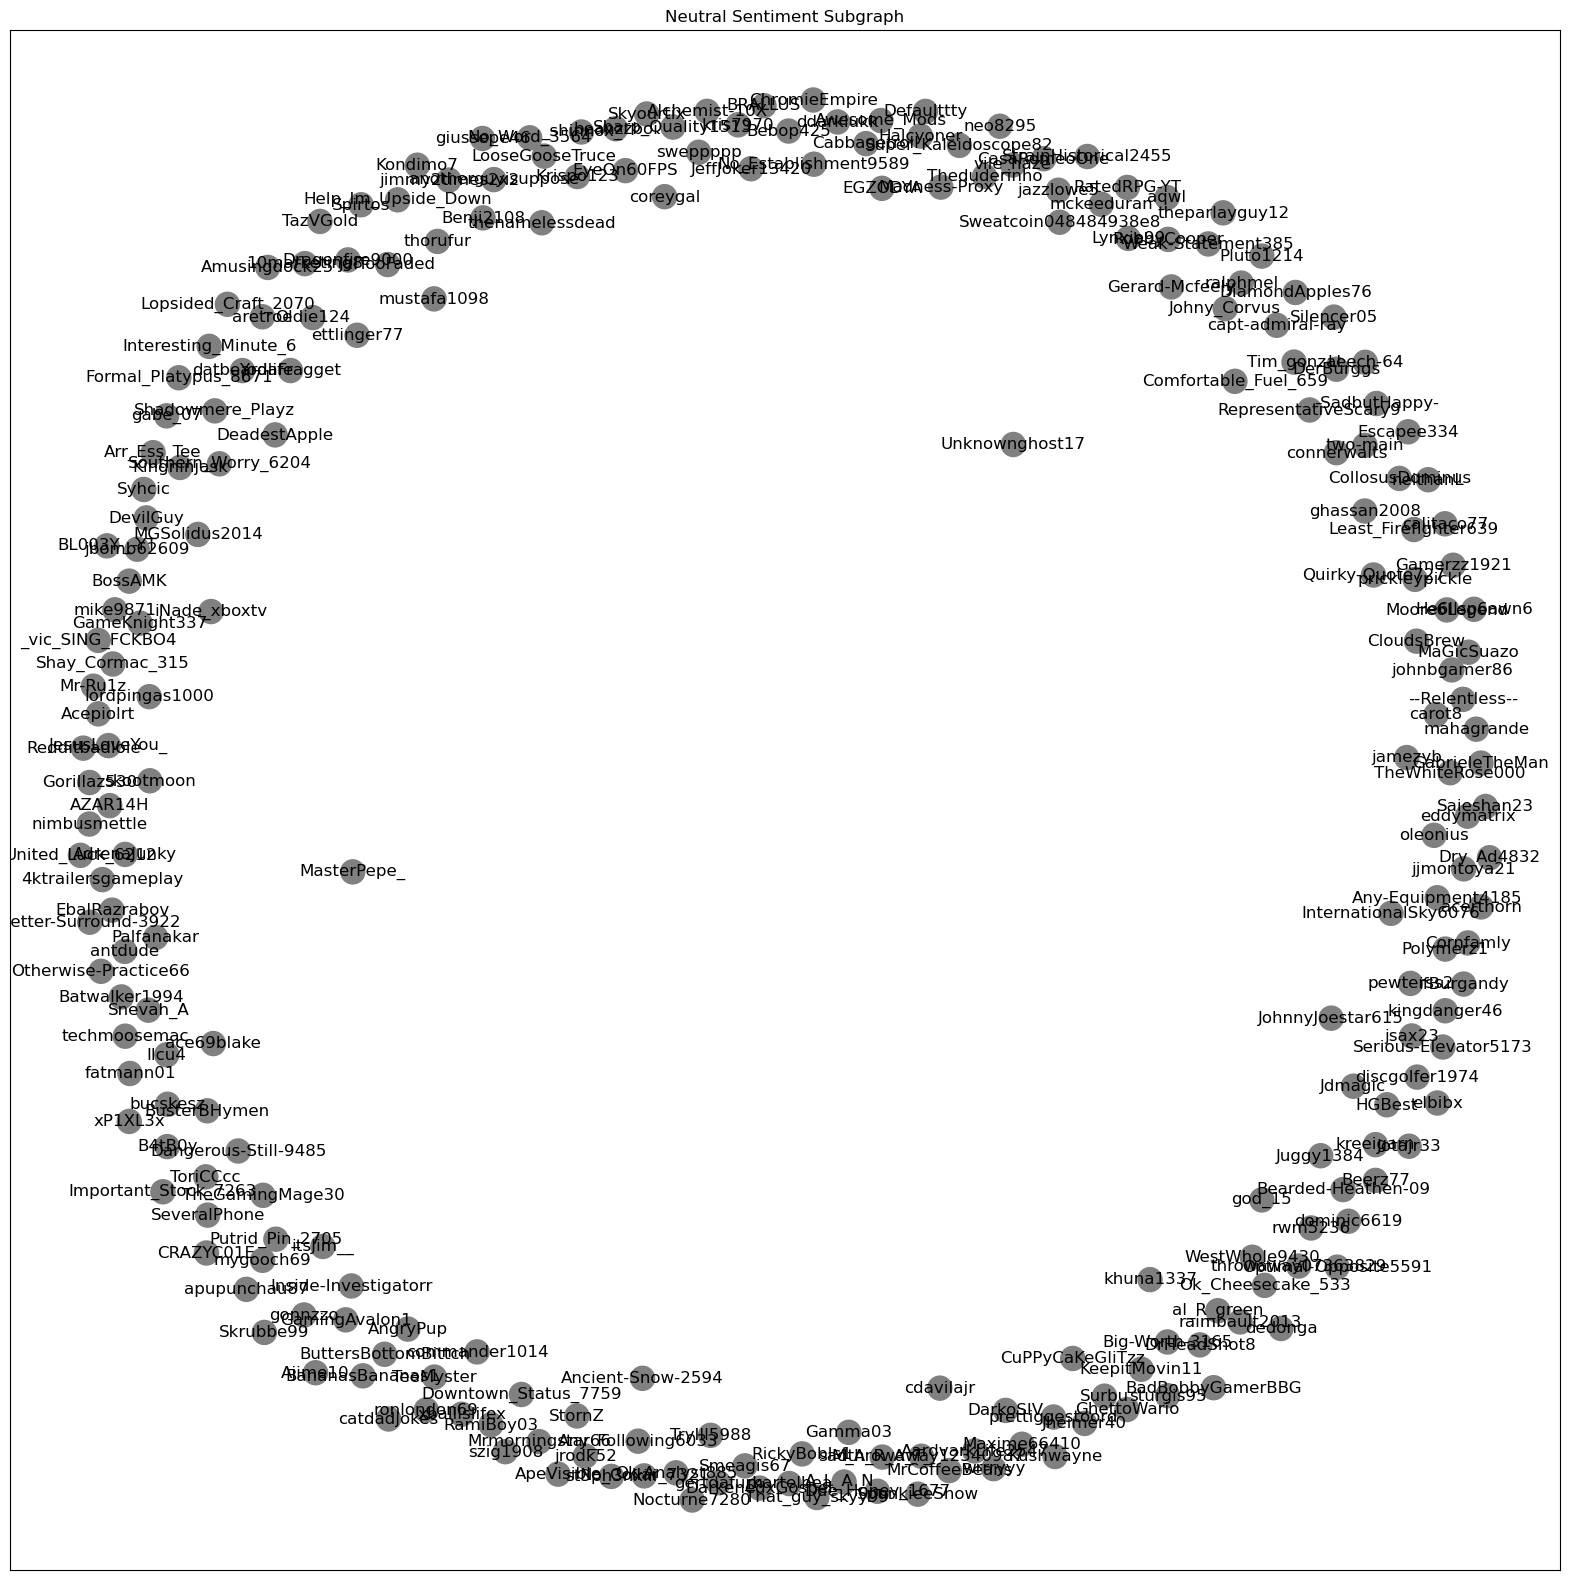

In [9]:
# Create subgraphs for positive, negative, and neutral sentiment scores
positive_nodes = [node for node in G.nodes() if personal_sentiment_scores_df[personal_sentiment_scores_df['author_name'] == node]['personal_sentiment_score'].values > 0]
positive_G = G.subgraph(positive_nodes)

negative_nodes = [node for node in G.nodes() if personal_sentiment_scores_df[personal_sentiment_scores_df['author_name'] == node]['personal_sentiment_score'].values < 0]
negative_G = G.subgraph(negative_nodes)

neutral_nodes = [node for node in G.nodes() if personal_sentiment_scores_df[personal_sentiment_scores_df['author_name'] == node]['personal_sentiment_score'].values == 0]
neutral_G = G.subgraph(neutral_nodes)

# Set node colors based on sentiment scores
positive_node_colors = ['green' if personal_sentiment_scores_df[personal_sentiment_scores_df['author_name'] == node]['personal_sentiment_score'].values > 0 else 'gray' for node in positive_G.nodes()]
negative_node_colors = ['red' if personal_sentiment_scores_df[personal_sentiment_scores_df['author_name'] == node]['personal_sentiment_score'].values < 0 else 'gray' for node in negative_G.nodes()]
neutral_node_colors = ['gray' for node in neutral_G.nodes()]

# Plot positive sentiment subgraph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(positive_G, seed=42)
nx.draw_networkx(positive_G, pos, with_labels=True, node_color=positive_node_colors)
plt.title("Positive Sentiment Subgraph")
plt.show()

# Plot negative sentiment subgraph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(negative_G, seed=42)
nx.draw_networkx(negative_G, pos, with_labels=True, node_color=negative_node_colors)
plt.title("Negative Sentiment Subgraph")
plt.show()

# Plot neutral sentiment subgraph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(neutral_G, seed=42)
nx.draw_networkx(neutral_G, pos, with_labels=True, node_color=neutral_node_colors)
plt.title("Neutral Sentiment Subgraph")
plt.show()

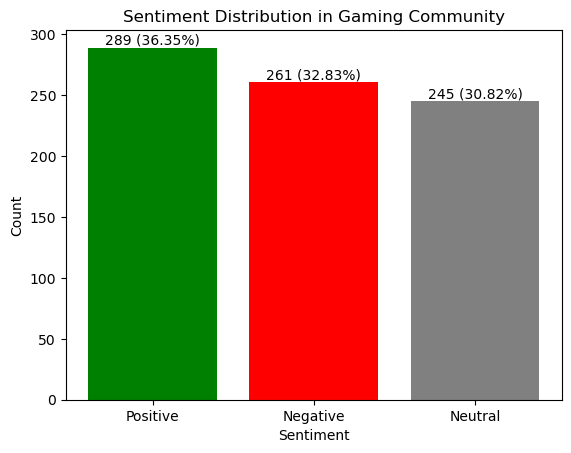

In [10]:
positive_count = len(positive_nodes)
negative_count = len(negative_nodes)
neutral_count = len(neutral_nodes)

total_count = positive_count + negative_count + neutral_count

# Calculate percentage of each sentiment category
positive_percentage = (positive_count / total_count) * 100
negative_percentage = (negative_count / total_count) * 100
neutral_percentage = (neutral_count / total_count) * 100

# Create a bar graph
sentiment_labels = ['Positive', 'Negative', 'Neutral']
sentiment_counts = [positive_count, negative_count, neutral_count]
plt.bar(sentiment_labels, sentiment_counts, color=['green', 'red', 'gray'])

# Display percentage values on the graph
for i in range(len(sentiment_labels)):
    plt.text(sentiment_labels[i], sentiment_counts[i], f'{sentiment_counts[i]} ({round(sentiment_counts[i] / total_count * 100, 2)}%)', ha='center', va='bottom')

# Set the title and labels for the graph
plt.title('Sentiment Distribution in Gaming Community')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display the graph
plt.show()

In [11]:
top_50_negative_users.head(5)

author_name  personal_sentiment_score
63             cdubfs540                  -0.80000
656    FunEquivalent7811                  -0.80000
747             Hawk2727                  -0.80000
317  lizard_wizardlizard                  -0.78125
745             micco_42                  -0.60000

In [12]:
post_authors_df = Activision_DF[['author_name', 'post_title', 'post_text']].drop_duplicates(subset='author_name')
post_authors_df = post_authors_df[post_authors_df['author_name'] != '[deleted]']


# Create a dataframe with the list of authors who commented (including subcomments)
comment_authors = []
for post in Activision_posts:
    for comment in post['comments']:
        if comment['author_name'] != '[deleted]':
            comment_authors.append((comment['author_name'], comment['comment']))
            for subcomment in comment['subcomments']:
                if subcomment['author_name'] != '[deleted]':
                    comment_authors.append((subcomment['author_name'], subcomment['comment']))
comment_authors_df = pd.DataFrame(comment_authors,columns=['author_name', 'comment'])
comment_authors_df = comment_authors_df.drop_duplicates(subset='author_name')
comment_authors_df = comment_authors_df[comment_authors_df['author_name'] != '[deleted]']

print('Post authors:')
display(post_authors_df.head())

print('Comment authors:')
display(comment_authors_df.head())

Post authors:


author_name                                         post_title  \
0           BRALLUS  [MW] This one is for the people complaining ab...   
1         RayShotz_  All PC and Xbox users on here complaining abou...   
2           hari333                               Ban all PC crossplay   
3       Snowinater3  Why are there so many pride flags but not a si...   
4  Mission_Carrot65                     Want to help, All COD players.   

                                           post_text  
0                                                     
1                                                     
2  As a PS5 gamer I feel sorry for the Xbox gamer...  
3                                                     
4  Please read the entire guide. I'm new here to ...

Comment authors:


author_name                                            comment
0        Ghostdogz                                              THIS!
1  EverythingUfear                                     #youAreToxicAF
2        RayShotz_  Thank you bro, you know you try but you just n...
3        L3GiiT818  I’m a long time ps player and i think this is ...
4     kwally_cuero  Do people not remember when COD was exclusive ...

In [13]:
freq_authors = Activision_DF[Activision_DF.duplicated(['author_name'], keep = False)] #Authors who has posted more than once
freq_authors.head(5)

author_name         time_posted  total_comments  upvotes  \
0         BRALLUS 2019-10-29 19:41:03               1        0   
2         hari333 2022-11-02 13:49:40              43        3   
7  lordpingas1000 2020-04-06 17:02:43               0        0   
8    DeadestApple 2020-04-06 07:01:36               0        0   
9    YoungScabies 2019-12-15 04:29:08               3        0   

                                          post_title  \
0  [MW] This one is for the people complaining ab...   
2                               Ban all PC crossplay   
7                                         SKYLANDERS   
8                                      Skylanders 7?   
9  Fortnite really kicked your fuckin dick in the...   

                                           post_text  \
0                                                      
2  As a PS5 gamer I feel sorry for the Xbox gamer...   
7                                                      
8  #BringSkylandersBack\n\n[View Poll](https://ww...   
9  Honestly I’m embarrassed for you. Look at fort...   

                                            comments  sentiment_score  \
0  [{'comment': 'THIS!', 'author_name': 'Ghostdog...         0.000000   
2  [{'comment': 'It’s funny because I play on PC ...         0.337473   
7                                                 []         0.000000   
8                                                 []         0.000000   
9  [{'comment': 'Damn son, which game has your pa...        -0.221875   

   num_comments  
0             1  
2            10  
7             0  
8             0  
9             1

In [14]:
freq_authors = freq_authors[freq_authors.author_name != 'None']
freq_authors = freq_authors[freq_authors.author_name != '[deleted]']

Text(0, 0.5, 'Number of posts')

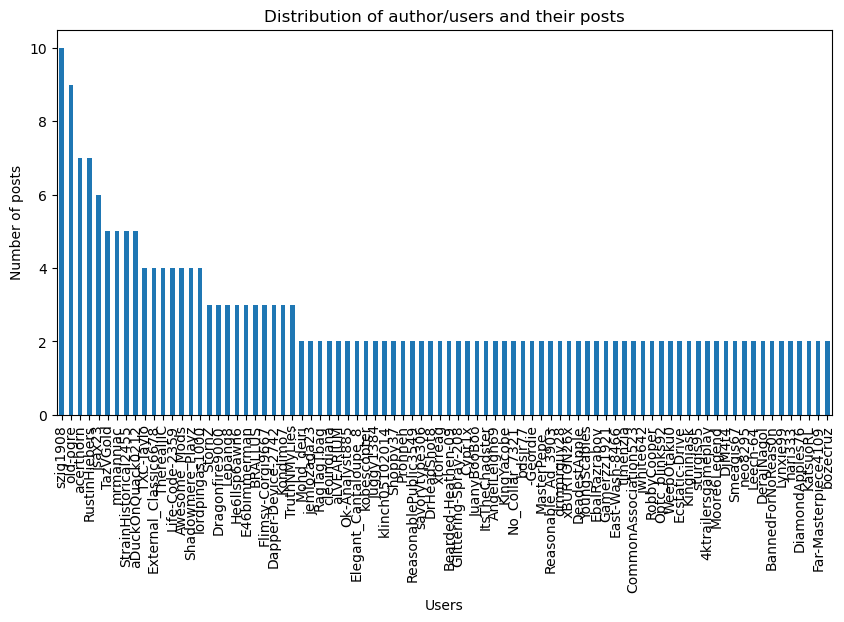

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
ax = freq_authors['author_name'].value_counts().plot(kind='bar',title='Distribution of author/users and their posts')
ax.set_xlabel("Users")
ax.set_ylabel("Number of posts")

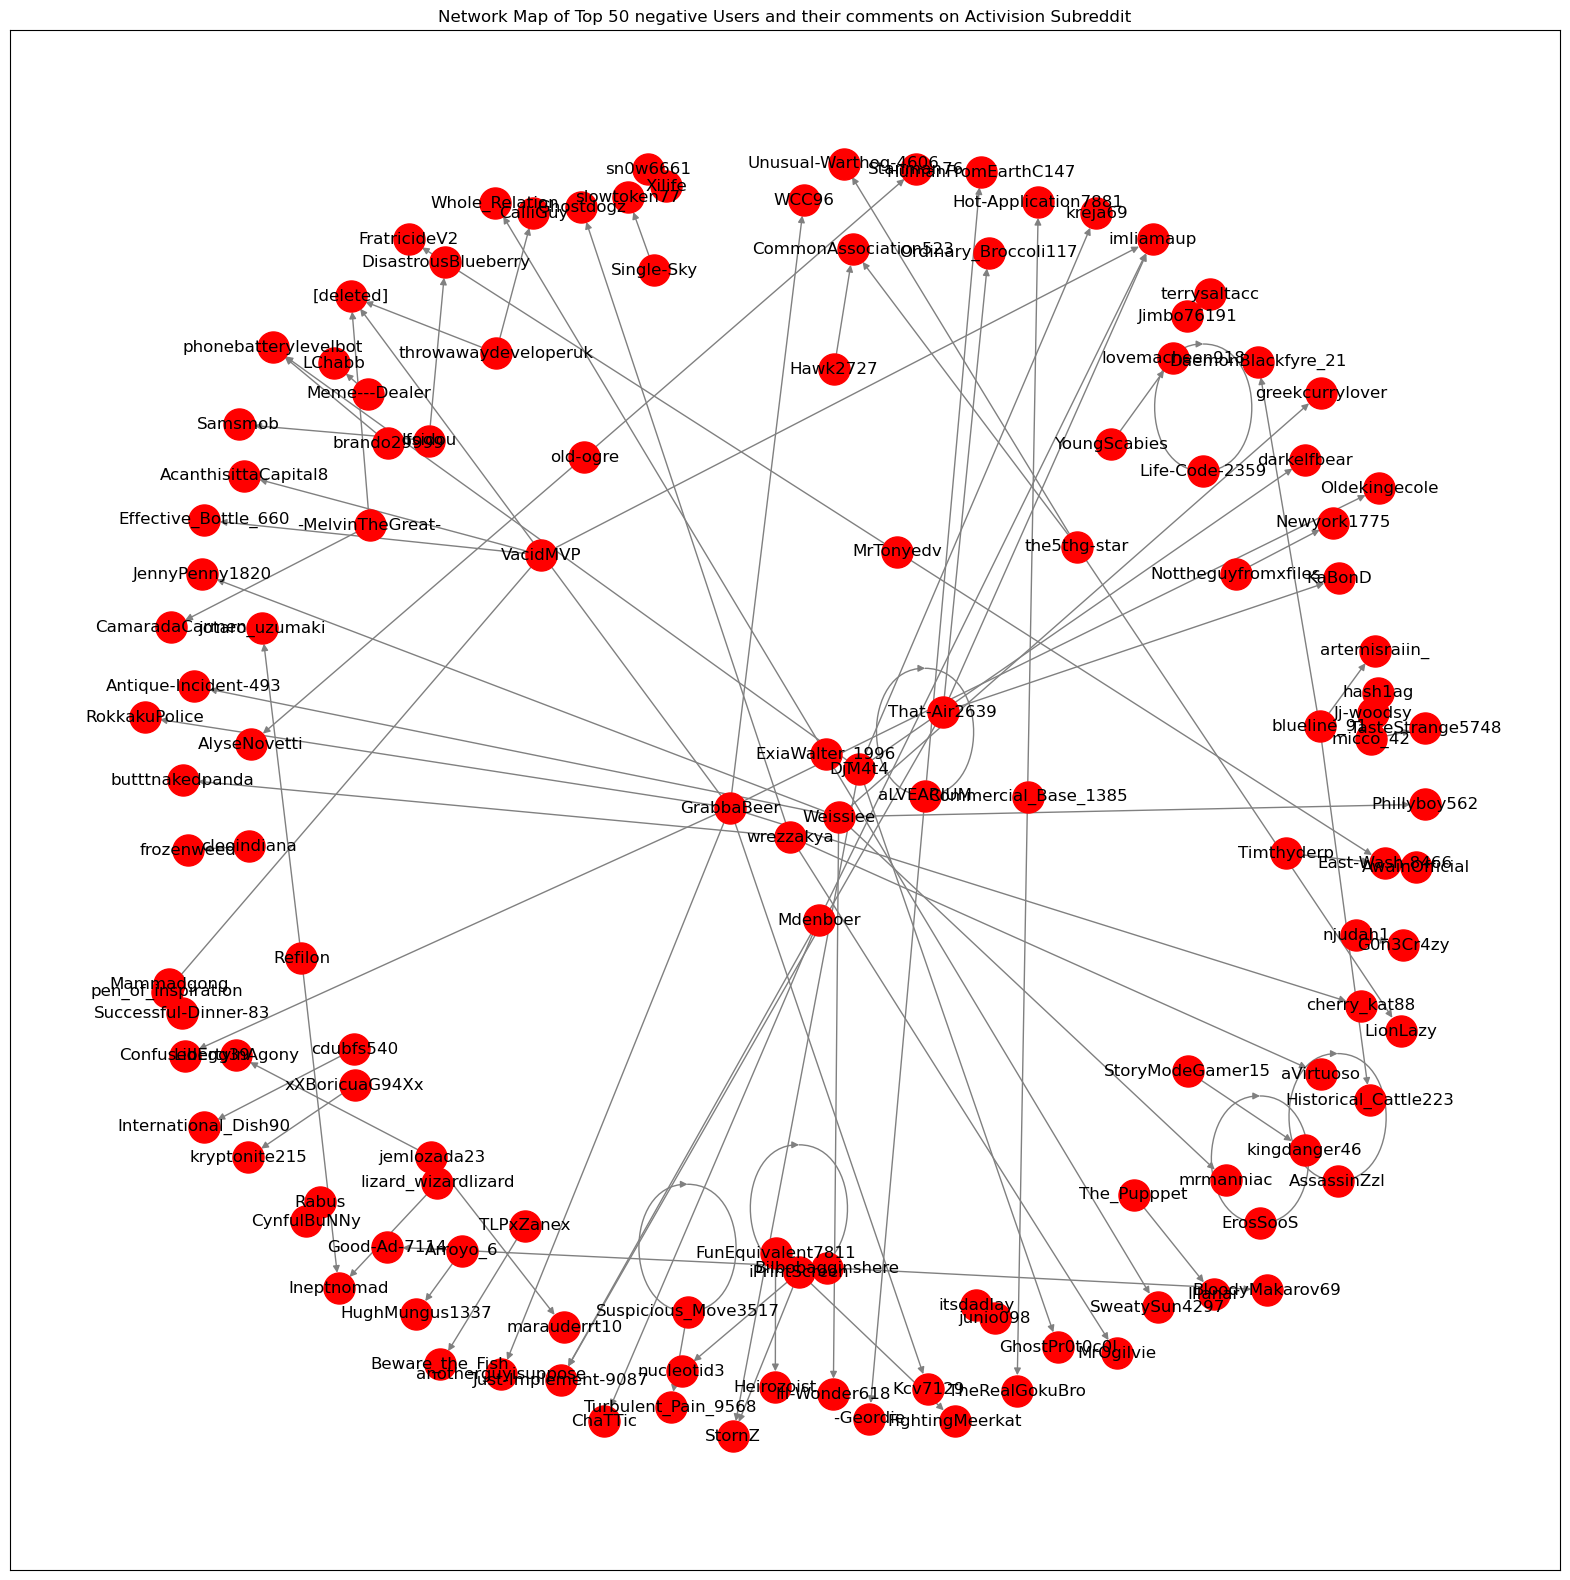

In [16]:
# Create a directed graph for negative users
negative_graph = nx.DiGraph()
for user in top_50_negative_users['author_name']:
    user_comments = Activision_DF[Activision_DF['author_name'] == user]['comments'].values[0]
    for comment in user_comments:
        negative_graph.add_edge(user, comment['author_name'])

# Plot the positive graph
plt.figure(figsize=(20, 20))
nx.draw_networkx(negative_graph, with_labels=True, node_size=500, font_size=12, node_color='red', edge_color='gray', arrowsize=10)
plt.title('Network Map of Top 50 negative Users and their comments on Activision Subreddit')
plt.show()

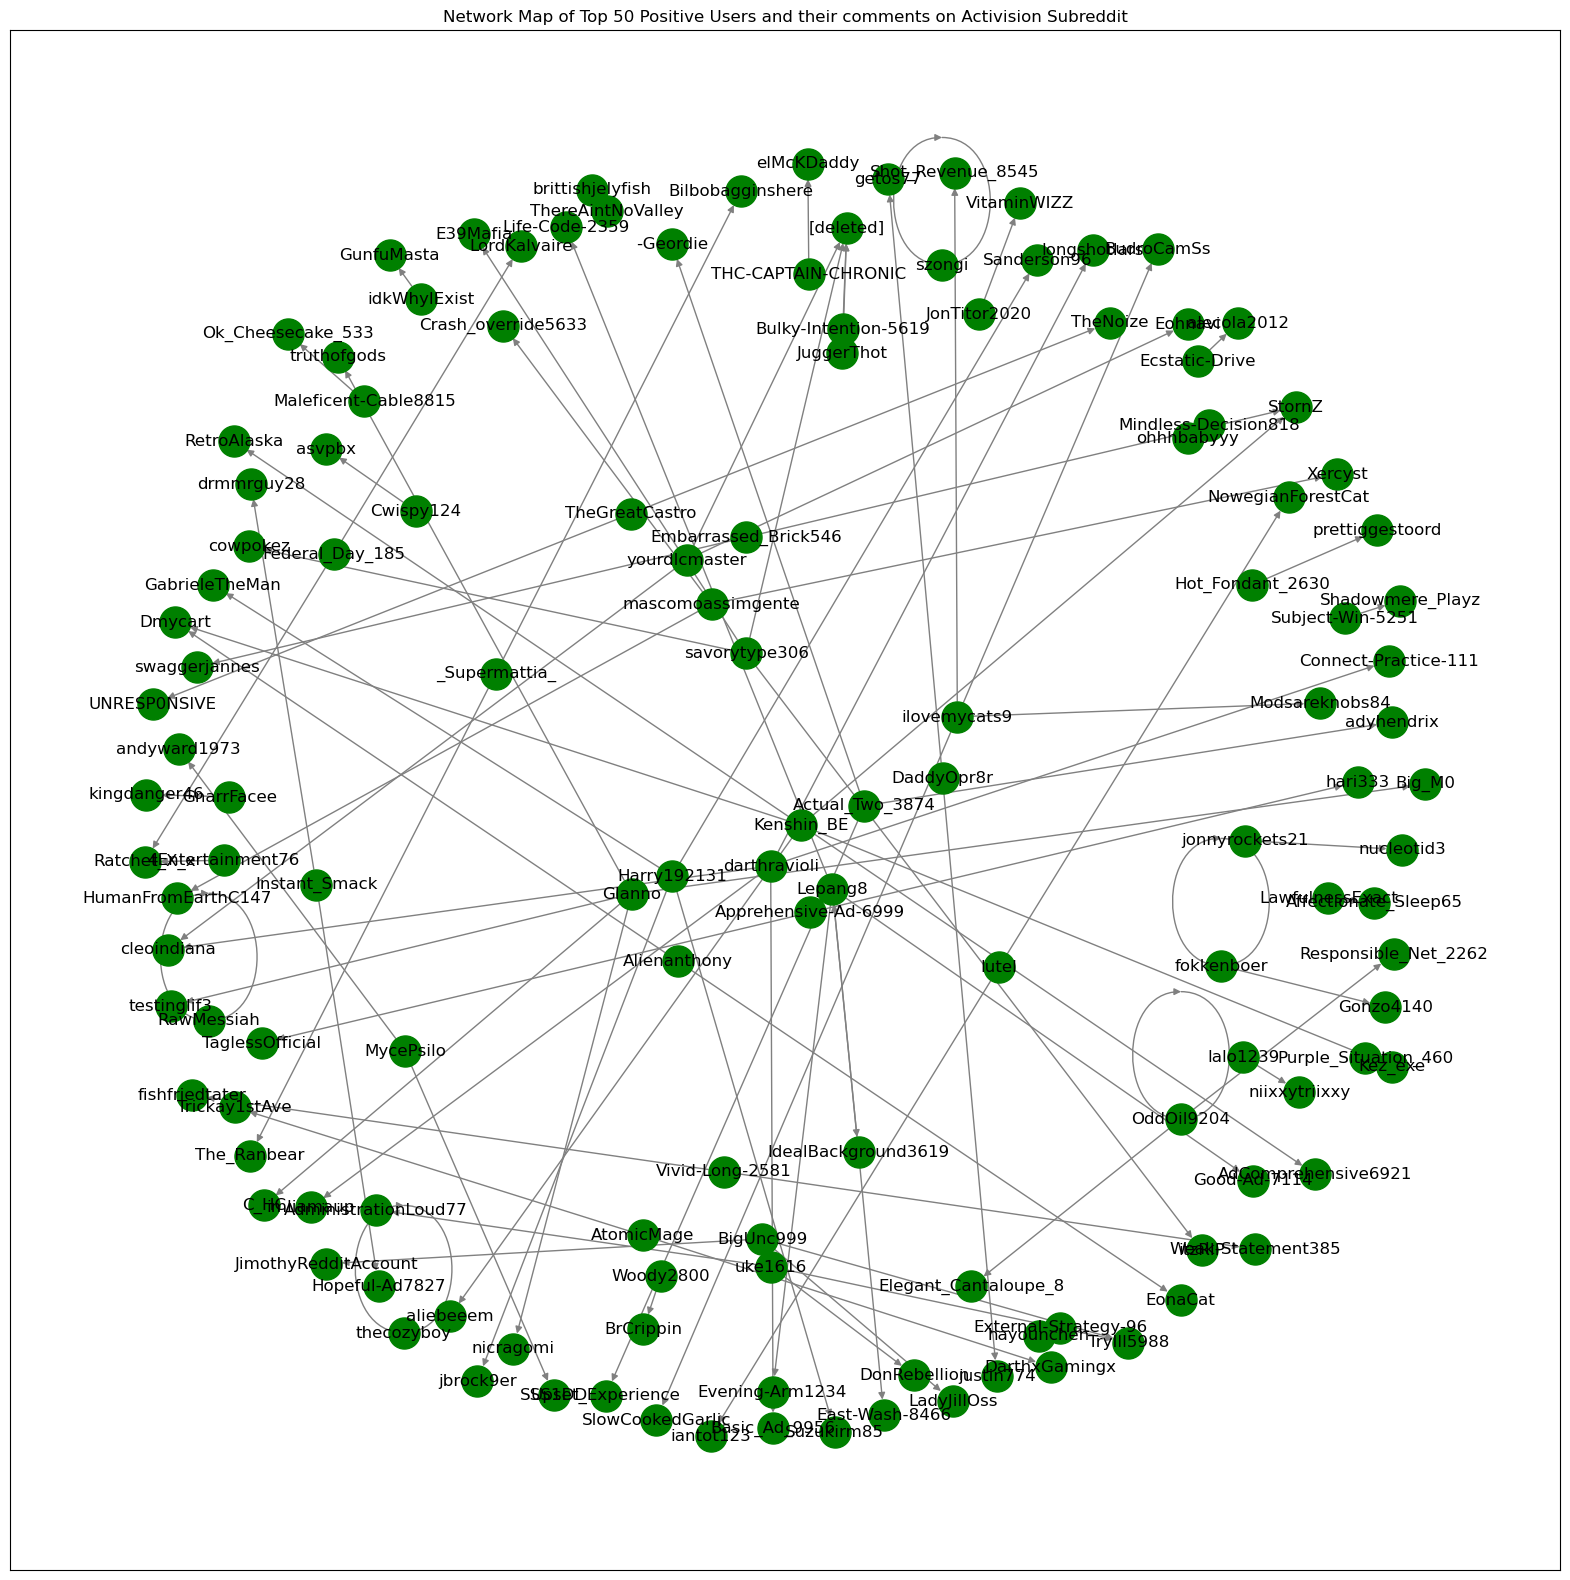

In [17]:
# Create a directed graph for positive users
positive_graph = nx.DiGraph()
for user in top_50_positive_users['author_name']:
    user_comments = Activision_DF[Activision_DF['author_name'] == user]['comments'].values[0]
    for comment in user_comments:
        positive_graph.add_edge(user, comment['author_name'])

# Plot the positive graph
plt.figure(figsize=(20, 20))
nx.draw_networkx(positive_graph, with_labels=True, node_size=500, font_size=12, node_color='green', edge_color='gray', arrowsize=10)
plt.title('Network Map of Top 50 Positive Users and their comments on Activision Subreddit')
plt.show()

In [18]:
# Authenticate using your Reddit API credentials
import time
reddit = praw.Reddit(client_id="UJB8dd4JEV3M405S2NTn1g",  # your client id
                     client_secret="Mc3huEYmHcU6c0HSTOZLefZqLZqHHw",  # your client secret
                     user_agent="EpicGames")  # your user agent

author_list1 = top_50_positive_users['author_name'].tolist()
author_list2 = top_50_negative_users['author_name'].tolist()
pos_neg_users = author_list1 + author_list2

# Create an empty DataFrame with desired column names
df_pos_neg_users = pd.DataFrame(columns=['user', 'comment', 'time_posted'])

# Retrieve the 50 recent comments from each user and append to the DataFrame
for user in pos_neg_users:
    redditor = reddit.redditor(user)
    try:
        comments = redditor.comments.new(limit=50)
        for comment in comments:
            df_pos_neg_users = df_pos_neg_users.append({'user': user, 'comment': comment.body, 'time_posted': comment.created_utc}, ignore_index=True)
        time.sleep(2) # rate limiting
    except Exception as e:
        print(f"Error processing user {user}: {e}")

df_pos_neg_users.to_csv("Contro_pos_neg_comments.csv", index=False)

Error processing user ThereAintNoValley: received 403 HTTP response
Error processing user darthravioli: received 403 HTTP response
Error processing user JonTitor2020: received 403 HTTP response
Error processing user Refilon: received 403 HTTP response
Error processing user YoungScabies: received 403 HTTP response
Error processing user GrabbaBeer: received 403 HTTP response


In [19]:
# Create a new dataframe to store the karma of each author
Karma_df = pd.DataFrame(columns=['author_name', 'karma'])

# Loop through each author name in the list
for author in pos_neg_users:
    # Select rows from Activision_DF where author_name is equal to the current author
    author_rows = Activision_DF[Activision_DF['author_name'] == author]
    
    # Calculate the total karma for the author
    author_karma = author_rows['upvotes'].sum()
    
    # Add the author name and karma to the new dataframe
    Karma_df = Karma_df.append({'author_name': author, 'karma': author_karma}, ignore_index=True)

Karma_df.head(5)
#profile value -- how many upvotes & down votes

author_name karma
0  Mindless-Decision818     1
1              lalo1239     2
2            DaddyOpr8r     5
3          idkWhyIExist     4
4     ThereAintNoValley     2

In [20]:
# Initialize dataframe to store results
trophies_df = pd.DataFrame(columns=['author_name', 'trophies'])

# Loop over each username and retrieve their trophy information
for username in pos_neg_users:
    user = reddit.redditor(username)
    trophies = list(user.trophies())
    trophies_list = [trophy.name for trophy in trophies]
    trophies_df = trophies_df.append({'author_name': username, 'trophies': trophies_list}, ignore_index=True)

trophies_df.head(5)

author_name                                           trophies
0  Mindless-Decision818                                                 []
1              lalo1239                                  [Three-Year Club]
2            DaddyOpr8r  [Two-Year Club, Powerups Hero, Gilding II, Red...
3          idkWhyIExist                   [Five-Year Club, Verified Email]
4     ThereAintNoValley                                    [Six-Year Club]

In [21]:
import datetime

# Create an empty dataframe to store the cake day information
cake_day_df = pd.DataFrame(columns=['author_name', 'cake_day'])

# Loop through the list of author names
for author_name in pos_neg_users:
    try:
        # Get the redditor object
        redditor = reddit.redditor(author_name)
        # Get the UTC timestamp of the cake day
        cake_day = redditor.created_utc
        # Convert UTC timestamp to datetime object
        cake_day_datetime = datetime.datetime.utcfromtimestamp(cake_day)
        # Format datetime object to date-month-year string
        cake_day_str = cake_day_datetime.strftime('%d-%m-%Y')
        # Append the author name and cake day to the dataframe
        cake_day_df = cake_day_df.append({'author_name': author_name, 'cake_day': cake_day_str}, ignore_index=True)
    except Exception as e:
        print(f"Error getting cake day for author {author_name}: {e}")

# Print the first 4 rows of the dataframe
print(cake_day_df.head(4))

Error getting cake day for author ThereAintNoValley: 'Redditor' object has no attribute 'created_utc'
Error getting cake day for author darthravioli: 'Redditor' object has no attribute 'created_utc'
Error getting cake day for author JonTitor2020: 'Redditor' object has no attribute 'created_utc'
Error getting cake day for author Refilon: 'Redditor' object has no attribute 'created_utc'
Error getting cake day for author YoungScabies: 'Redditor' object has no attribute 'created_utc'
Error getting cake day for author GrabbaBeer: 'Redditor' object has no attribute 'created_utc'
            author_name    cake_day
0  Mindless-Decision818  27-11-2022
1              lalo1239  21-03-2020
2            DaddyOpr8r  11-09-2020
3          idkWhyIExist  17-08-2017


In [22]:
# Create a new dataframe containing only the rows with authors in author_list1
df_filtered = Activision_DF[Activision_DF['author_name'].isin(pos_neg_users)]
df_filtered1 = Activision_DF[Activision_DF['author_name'].isin(author_list1)]
df_filtered2 = Activision_DF[Activision_DF['author_name'].isin(author_list2)]

# Count the number of posts made by each user
post_counts = df_filtered['author_name'].value_counts()
post_counts1 = df_filtered1['author_name'].value_counts()
post_counts2 = df_filtered2['author_name'].value_counts()

# Print the top 10 users with the most posts
print("Top50 negative & postivie users who has posted more often:\n", post_counts.head(5),"Top50 postivie users who has posted more often:\n", post_counts1.head(5),"Top50 negative users who has posted more often:\n", post_counts2.head(5))

Top50 negative & postivie users who has posted more often:
 old-ogre          9
Life-Code-2359    4
Lepang8           3
Ecstatic-Drive    2
DjM4t4            2
Name: author_name, dtype: int64 Top50 postivie users who has posted more often:
 Lepang8           3
savorytype306     2
Ecstatic-Drive    2
thecozyboy        1
uke1616           1
Name: author_name, dtype: int64 Top50 negative users who has posted more often:
 old-ogre          9
Life-Code-2359    4
YoungScabies      2
aLVEARIUM         2
cleoindiana       2
Name: author_name, dtype: int64


In [23]:
# Perform sentiment analysis for all comments of the 100 users

# Add a new column to the DataFrame with sentiment scores for each comment
df_pos_neg_users['sentiment_score'] = df_pos_neg_users['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group the DataFrame by user and calculate the average sentiment score for each user
df_senti = df_pos_neg_users.groupby('user')['sentiment_score'].mean().reset_index()

# Print the resulting DataFrame
print(df_senti.head(5))

                   user  sentiment_score
0      -MelvinTheGreat-         0.146564
1      4Entertainment76         0.021033
2       Actual_Two_3874        -0.400000
3          Alienanthony         0.086260
4  Apprehensive-Ad-6999         0.063333


In [24]:
df_pos_neg_users

user                                            comment  \
0     Mindless-Decision818                  Are people dislike bombing a bot?   
1     Mindless-Decision818                      I liked boats hell I still do   
2     Mindless-Decision818  The urgency or cause would depend on where the...   
3     Mindless-Decision818  Those updates only add random bullshit without...   
4     Mindless-Decision818  Yea I always try to ease into it when I can bu...   
...                    ...                                                ...   
2884              VacidMVP  T250s arent all insane it just means they have...   
2885              VacidMVP  Basically every single aspect of mw2019 was be...   
2886        xXBoricuaG94Xx  Just go offline in solo mode, run 1 race on da...   
2887        xXBoricuaG94Xx  Add The Mini Map!! Without Mini Map The Game i...   
2888            Mammadgong                                               Nice   

       time_posted  sentiment_score  
0     1.682297e+09         0.000000  
1     1.681824e+09         0.600000  
2     1.681796e+09         0.150000  
3     1.679777e+09        -0.094286  
4     1.679715e+09        -0.250000  
...            ...              ...  
2884  1.680157e+09        -0.433333  
2885  1.680157e+09         0.165143  
2886  1.575754e+09         0.000000  
2887  1.568357e+09        -0.262500  
2888  1.676126e+09         0.600000  

[2889 rows x 4 columns]

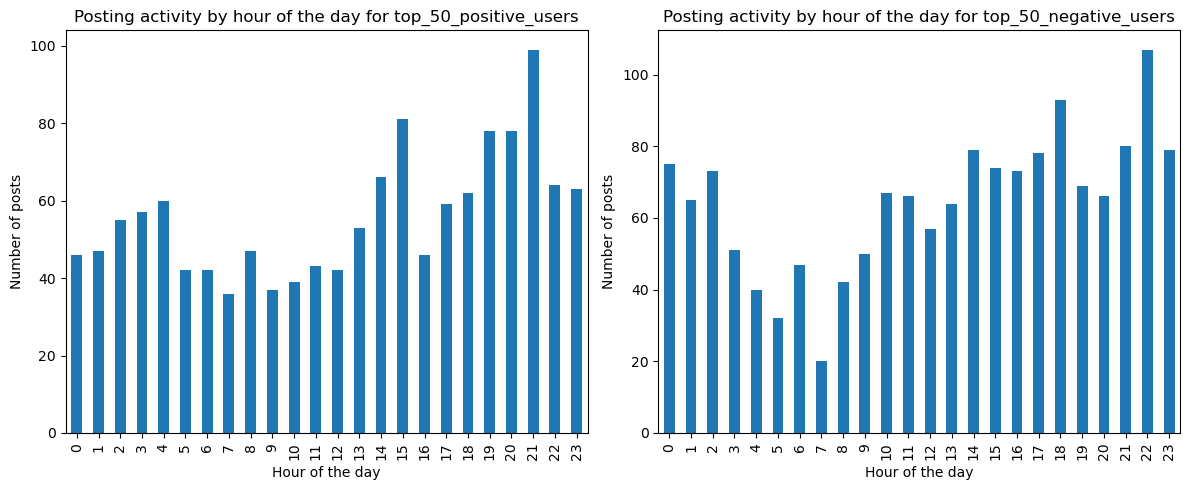

In [25]:
# Load the CSV file into a DataFrame
df_pos_neg_users = pd.read_csv("C:/Users/swapn/Contro_pos_neg_comments.csv")

# Extract the hour component from the "time_posted" column
df_pos_neg_users['hour_posted'] = pd.to_datetime(df_pos_neg_users['time_posted'], unit='s').dt.hour

# Filter the DataFrame to include only the top 50 positive and negative users
top_50_positive_users = df_pos_neg_users[df_pos_neg_users['user'].isin(author_list1)]
top_50_negative_users = df_pos_neg_users[df_pos_neg_users['user'].isin(author_list2)]

# Count the occurrences of each hour for positive users
positive_hour_counts = top_50_positive_users['hour_posted'].value_counts().sort_index()

# Count the occurrences of each hour for negative users
negative_hour_counts = top_50_negative_users['hour_posted'].value_counts().sort_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the hourly counts as bar charts in each subplot
positive_hour_counts.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Number of posts')
ax1.set_title('Posting activity by hour of the day for top_50_positive_users')

negative_hour_counts.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Hour of the day')
ax2.set_ylabel('Number of posts')
ax2.set_title('Posting activity by hour of the day for top_50_negative_users')

# Adjust the spacing between subplots and save the figure
plt.tight_layout()
plt.show()

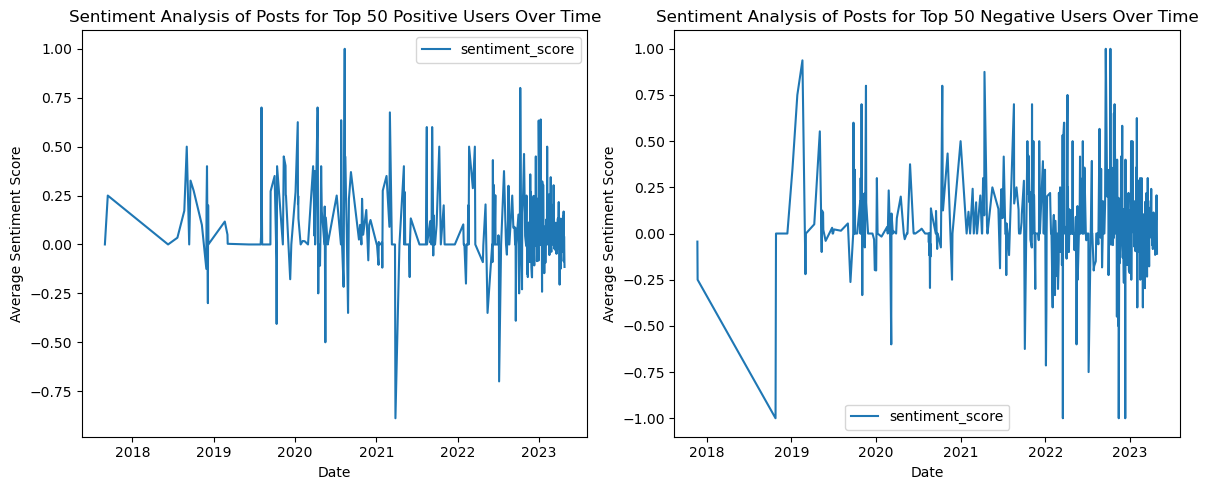

In [26]:
# Filter the DataFrame to include only comments from top 50 positive and negative users
top_50_positive_users = df_pos_neg_users[df_pos_neg_users['user'].isin(author_list1)]
top_50_negative_users = df_pos_neg_users[df_pos_neg_users['user'].isin(author_list2)]

# Convert the "time_posted" column to a datetime object
top_50_positive_users['time_posted'] = pd.to_datetime(top_50_positive_users['time_posted'], unit='s')
top_50_negative_users['time_posted'] = pd.to_datetime(top_50_negative_users['time_posted'], unit='s')

# Add a new column with date component for grouping
top_50_positive_users['date_posted'] = top_50_positive_users['time_posted'].dt.date
top_50_negative_users['date_posted'] = top_50_negative_users['time_posted'].dt.date

# Perform sentiment analysis for all comments
top_50_positive_users['sentiment_score'] = top_50_positive_users['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)
top_50_negative_users['sentiment_score'] = top_50_negative_users['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group the DataFrames by date and calculate the average sentiment score for each date
df_positive_sentiment_over_time = top_50_positive_users.groupby('date_posted')['sentiment_score'].mean().reset_index()
df_negative_sentiment_over_time = top_50_negative_users.groupby('date_posted')['sentiment_score'].mean().reset_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot the average sentiment scores as line charts in each subplot
df_positive_sentiment_over_time.plot(kind='line', x='date_posted', y='sentiment_score', ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Sentiment Score')
ax1.set_title('Sentiment Analysis of Posts for Top 50 Positive Users Over Time')

df_negative_sentiment_over_time.plot(kind='line', x='date_posted', y='sentiment_score', ax=ax2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Sentiment Score')
ax2.set_title('Sentiment Analysis of Posts for Top 50 Negative Users Over Time')

# Adjust the spacing between subplots and display the figure
plt.tight_layout()
plt.show()

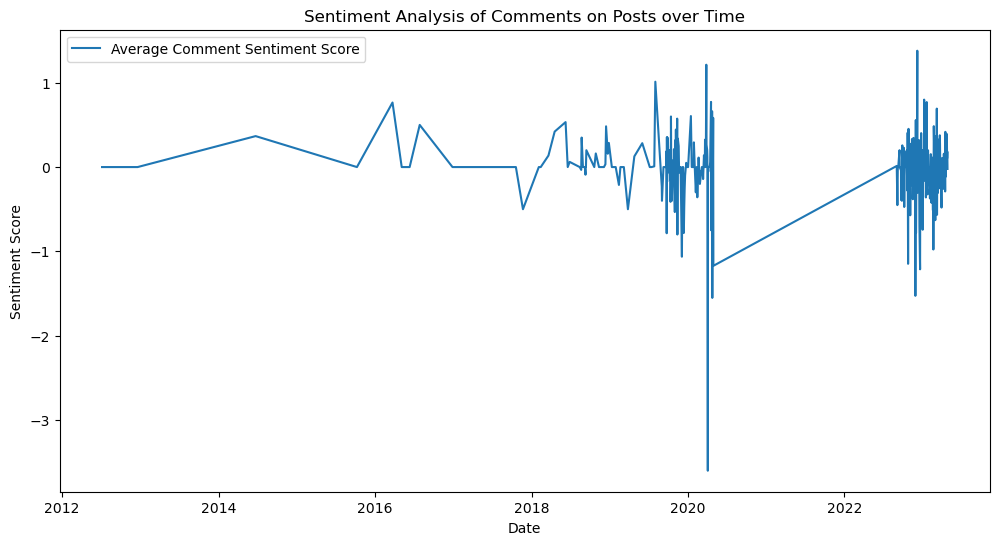

In [27]:
# Convert the "time_posted" column to a datetime object
Activision_DF['time_posted'] = pd.to_datetime(Activision_DF['time_posted'], format='%Y-%m-%d %H:%M:%S')
Activision_DF['date_posted'] = Activision_DF['time_posted'].dt.date

# Group the DataFrame by date
Activision_DF_grouped = Activision_DF.groupby('date_posted').agg({'sentiment_score': 'mean', 'num_comments': 'sum'}).reset_index()

# Plot sentiment analysis over time
plt.figure(figsize=(12, 6))
plt.plot(Activision_DF_grouped['date_posted'], Activision_DF_grouped['sentiment_score'], label='Average Comment Sentiment Score')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of Comments on Posts over Time')
plt.legend()
plt.show() 

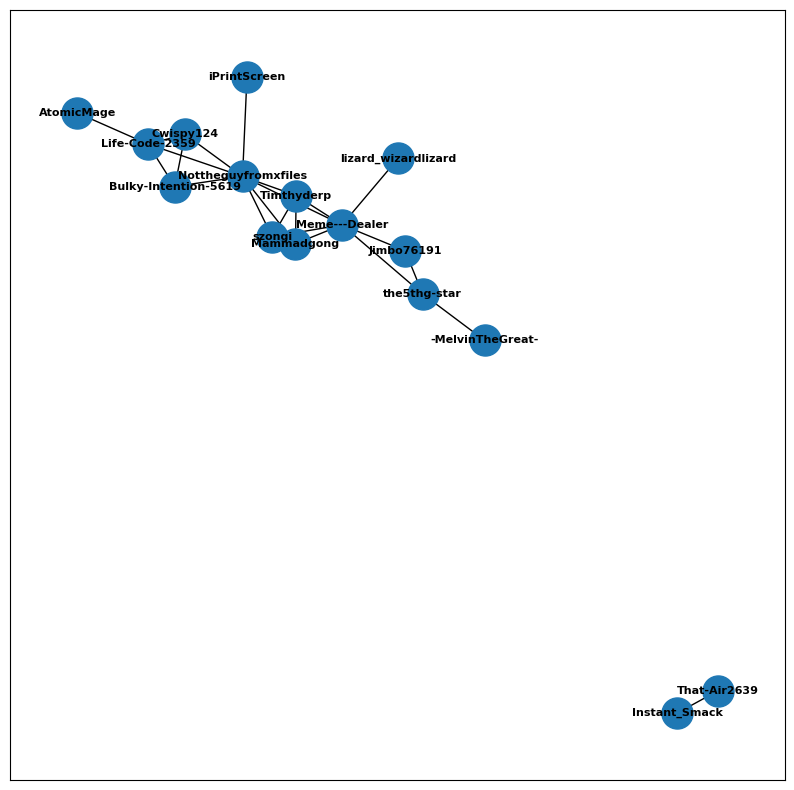

In [28]:
# Identify the list of users who have commented on each other's posts
user_pairs = []
for user1 in df_pos_neg_users['user'].unique():
    for user2 in df_pos_neg_users['user'].unique():
        if user1 != user2:
            comments1 = set(df_pos_neg_users[df_pos_neg_users['user'] == user1]['comment'])
            comments2 = set(df_pos_neg_users[df_pos_neg_users['user'] == user2]['comment'])
            if comments1 & comments2:
                user_pairs.append((user1, user2))

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph for each user
users = list(set([u1 for u1, u2 in user_pairs] + [u2 for u1, u2 in user_pairs]))
G.add_nodes_from(users)

# Add edges to the graph for pairs of users who have commented on each other's posts
G.add_edges_from(user_pairs)

# Adjust the layout and node placement of the graph
pos = nx.spring_layout(G, seed=42)

# Visualize the graph with adjusted layout, node placement, figure size, and font size
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos=pos, with_labels=True, node_size=500, font_size=8, font_weight='bold')
plt.show()

In [29]:
personal_sentiment_scores_dict = personal_sentiment_scores_df.set_index('author_name')['personal_sentiment_score'].to_dict()

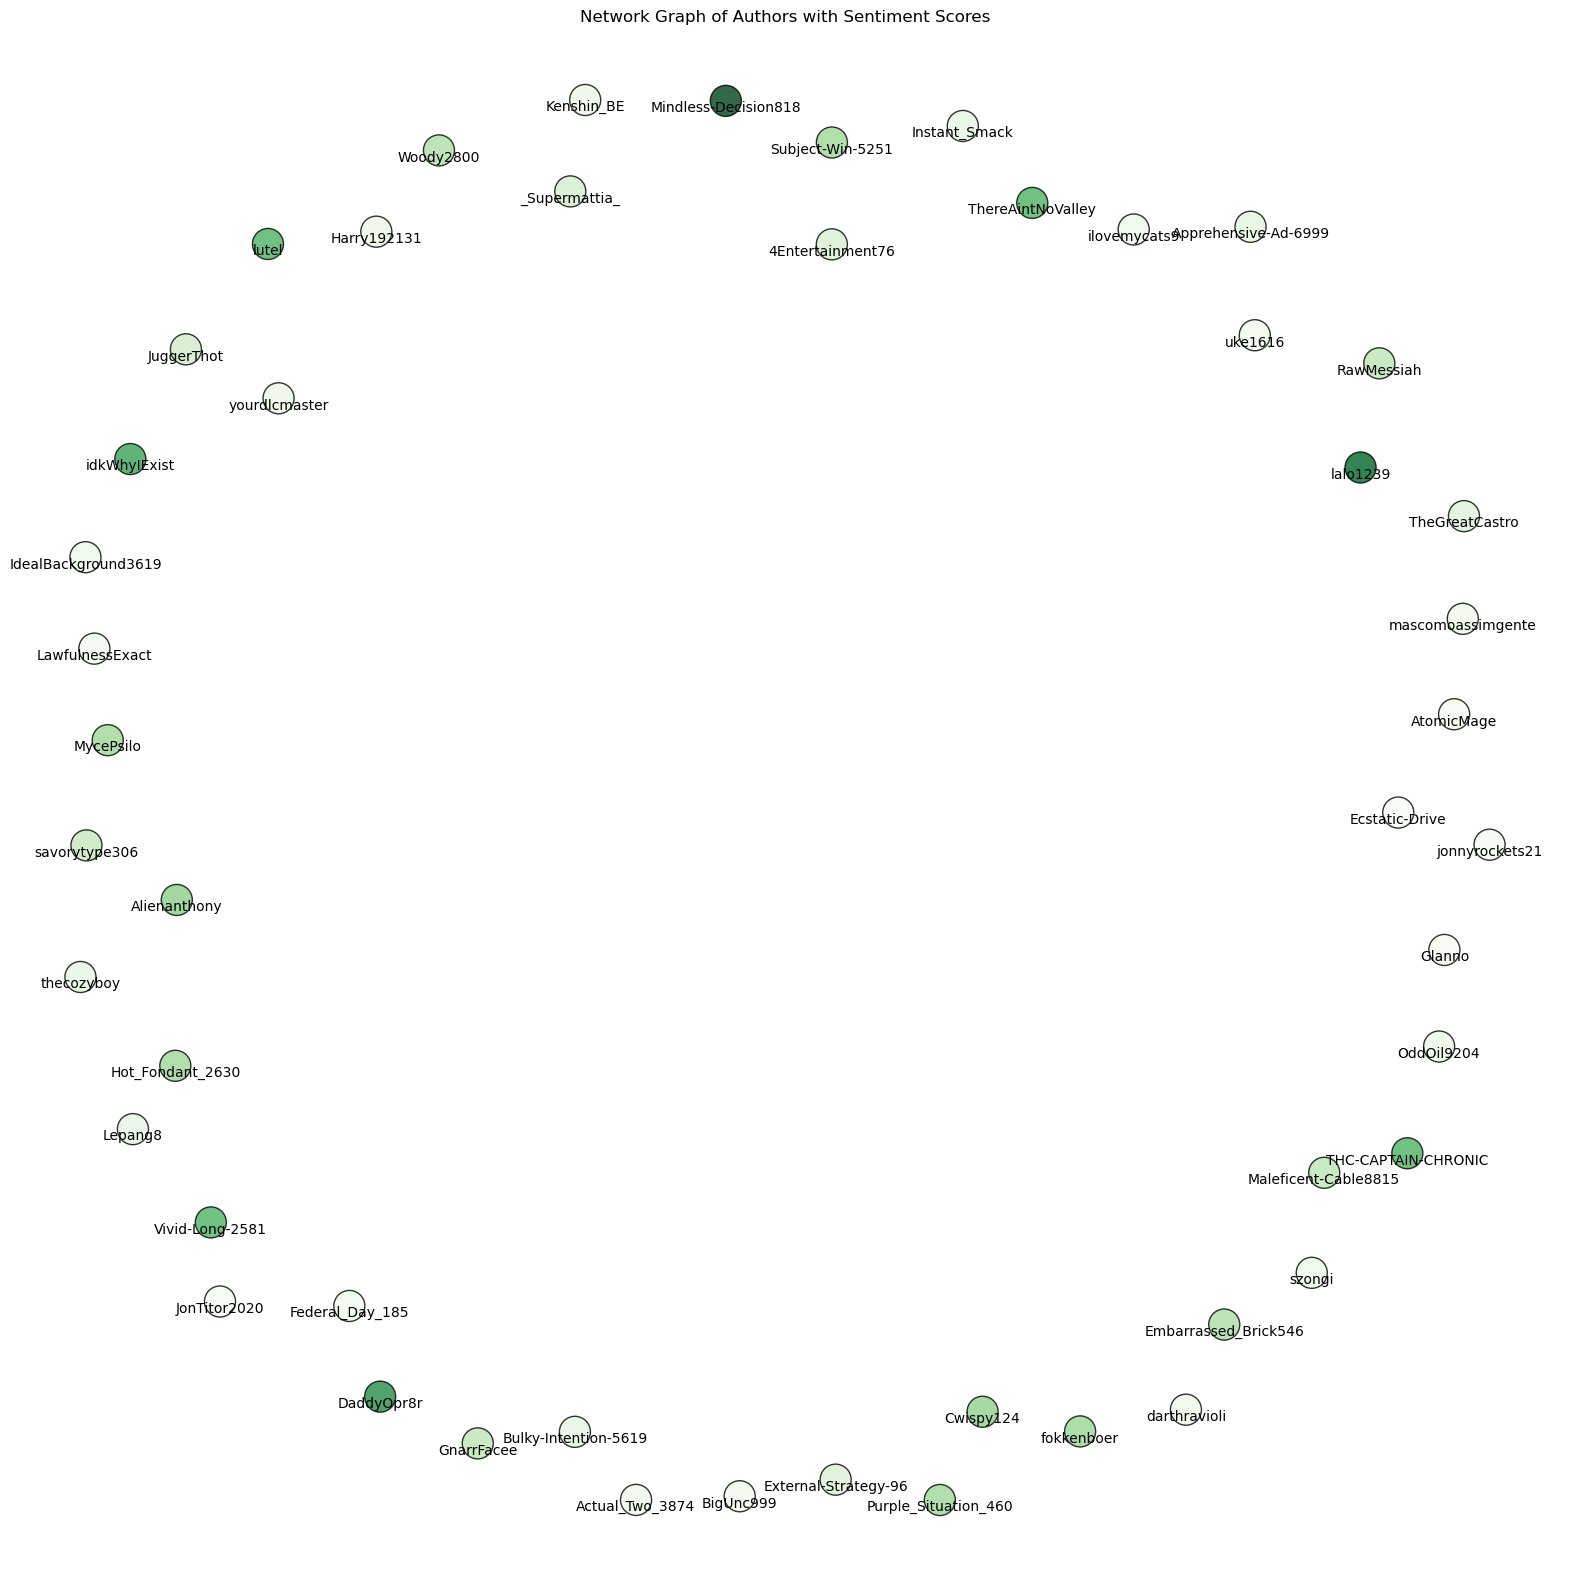

In [30]:
new_dict = {}

# Iterate through the author_list1 and check for matching names in the personal_sentiment_scores_dict
for author_name in author_list1:
    if author_name in personal_sentiment_scores_dict:
        sentiment_score = personal_sentiment_scores_dict[author_name]
        new_dict[author_name] = sentiment_score

# Create a graph object
G = nx.Graph()

# Add nodes to the graph
for author_name, sentiment_score in new_dict.items():
    G.add_node(author_name, sentiment_score=sentiment_score)

# Define the position layout for the graph
pos = nx.spring_layout(G, seed=42)

# Extract sentiment scores and colormap for node colors
node_colors = [G.nodes[n]['sentiment_score'] for n in G.nodes()]
cmap = plt.cm.Greens  # Use 'Greens' colormap for shades of green
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

# Create a larger plot with figsize
plt.figure(figsize=(20, 20))

# Draw nodes with varying colors based on sentiment scores
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=500, alpha=0.8, edgecolors='k', linewidths=1)

# Draw node labels just below the nodes
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, verticalalignment='top', font_size=10)

# Draw edges between nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Set plot title and show plot
plt.title('Network Graph of Authors with Sentiment Scores')
plt.axis('off')
plt.show()

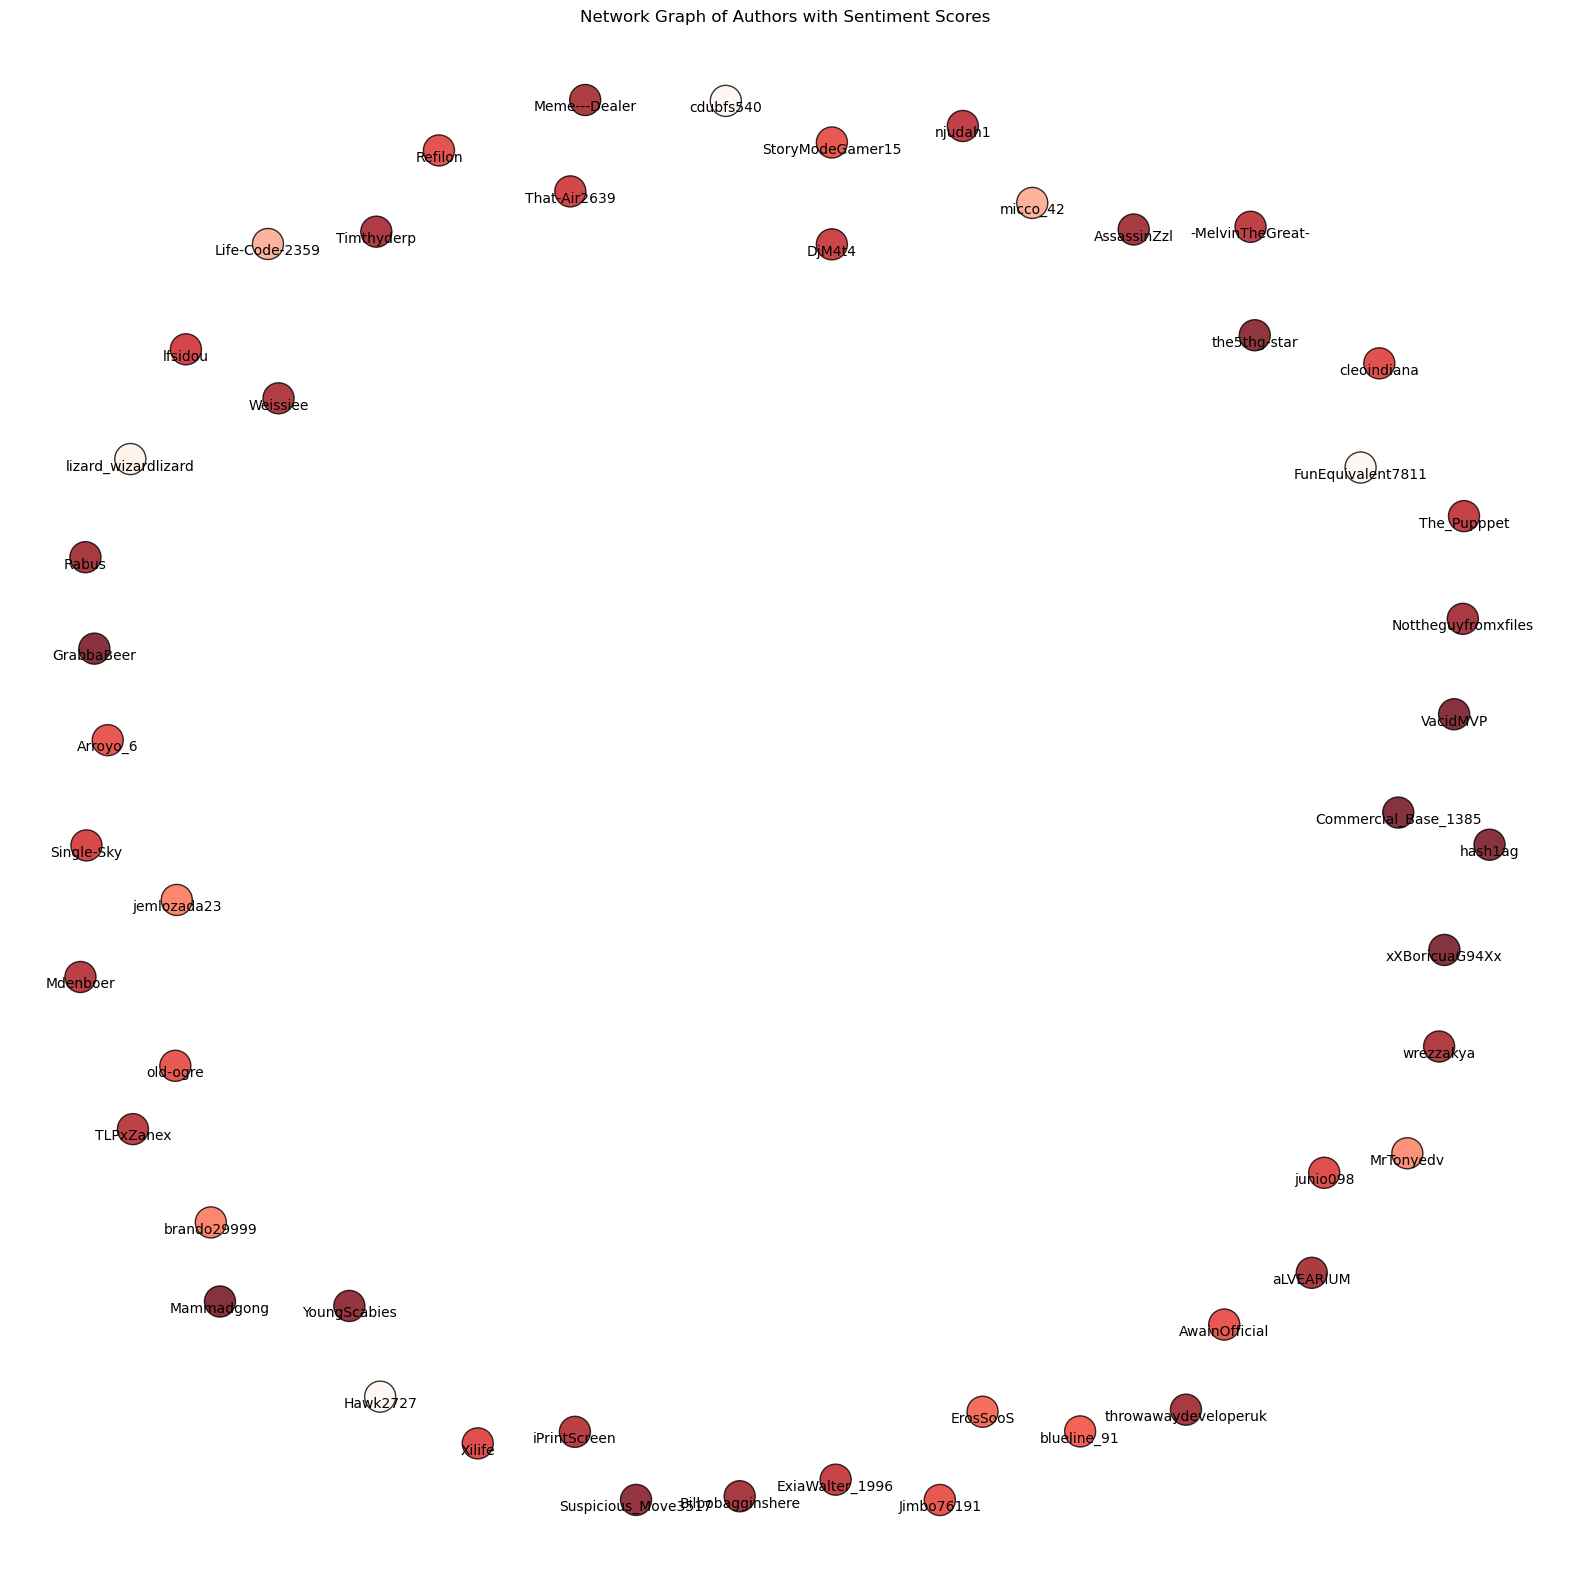

In [31]:
new_dict1 = {}

# Iterate through the author_list2 and check for matching names in the personal_sentiment_scores_dict
for author_name in author_list2:
    if author_name in personal_sentiment_scores_dict:
        sentiment_score = personal_sentiment_scores_dict[author_name]
        new_dict1[author_name] = sentiment_score

# Create a graph object
G = nx.Graph()

# Add nodes to the graph
for author_name, sentiment_score in new_dict1.items():
    G.add_node(author_name, sentiment_score=sentiment_score)

# Define the position layout for the graph
pos = nx.spring_layout(G, seed=42)

# Extract sentiment scores and colormap for node colors
node_colors = [G.nodes[n]['sentiment_score'] for n in G.nodes()]
cmap = plt.cm.Reds  # Use 'Reds' colormap for shades of green
norm = plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))

# Create a larger plot with figsize
plt.figure(figsize=(20, 20))

# Draw nodes with varying colors based on sentiment scores
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=cmap, node_size=500, alpha=0.8, edgecolors='k', linewidths=1)

# Draw node labels just below the nodes
nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()}, verticalalignment='top', font_size=10)

# Draw edges between nodes
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Set plot title and show plot
plt.title('Network Graph of Authors with Sentiment Scores')
plt.axis('off')
plt.show()

In [32]:
# Create subgraph of negative nodes
negative_nodes = author_list2
negative_subgraph = G.subgraph(negative_nodes)

# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(negative_subgraph)

# Calculate degree centrality
degree = nx.degree_centrality(negative_subgraph)

# Calculate eigenvector centrality
eigenvector = nx.eigenvector_centrality(negative_subgraph)

# Print nodes with highest betweenness centrality
print("Nodes with highest betweenness centrality--------------------")
for node, value in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, value)

# Print nodes with highest degree centrality
print("Nodes with highest degree centrality--------------------")
for node, value in sorted(degree.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, value)
    
# Print nodes with highest eigenvector centrality
print("Nodes with highest eigenvector centrality--------------------")
for node, value in sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(node, value)

Nodes with highest betweenness centrality--------------------
cdubfs540 0.0
FunEquivalent7811 0.0
Hawk2727 0.0
lizard_wizardlizard 0.0
micco_42 0.0
Life-Code-2359 0.0
MrTonyedv 0.0
brando29999 0.0
jemlozada23 0.0
ErosSooS 0.0
Nodes with highest degree centrality--------------------
cdubfs540 0.0
FunEquivalent7811 0.0
Hawk2727 0.0
lizard_wizardlizard 0.0
micco_42 0.0
Life-Code-2359 0.0
MrTonyedv 0.0
brando29999 0.0
jemlozada23 0.0
ErosSooS 0.0
Nodes with highest eigenvector centrality--------------------
cdubfs540 0.1414213562373095
FunEquivalent7811 0.1414213562373095
Hawk2727 0.1414213562373095
lizard_wizardlizard 0.1414213562373095
micco_42 0.1414213562373095
Life-Code-2359 0.1414213562373095
MrTonyedv 0.1414213562373095
brando29999 0.1414213562373095
jemlozada23 0.1414213562373095
ErosSooS 0.1414213562373095


In [33]:
# Function to remove emojis from text
def remove_emojis(text):
    return demoji.replace(text, '')

# Function to clean and preprocess text
def clean_text(text):
    text = remove_emojis(text)
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize and stem
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

def get_sentiment(comment):
    blob = TextBlob(comment)
    sia = SentimentIntensityAnalyzer()
    pol_score = sia.polarity_scores(comment)
    sentiment_polarity = pol_score['compound']
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0.2:
        sentiment_label = "positive"
    elif sentiment_polarity < -0.2:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    #store result in a dictionary
    result = {"polarity": sentiment_polarity, 
             "subjectivity": sentiment_subjectivity,
             "sentiment": sentiment_label,
             "compound": sentiment_polarity}
    return result

# Combine all comments into a single list
all_comments = comment_authors_df['comment'].tolist()

# Clean and preprocess comments
cleaned_comments = [clean_text(comment) for comment in all_comments]

# Perform sentiment analysis on cleaned comments
sentiment_results = [get_sentiment(comment) for comment in cleaned_comments]

# Create a new DataFrame for sentiment analysis results
df = pd.DataFrame({'comment': all_comments, 'cleaned_comment': cleaned_comments, 'sentiment_results': sentiment_results})

# Extract compound scores from sentiment results
df['compound'] = df['sentiment_results'].apply(lambda x: x['compound'])

# Add label column based on compound score
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1

# Drop unnecessary columns
#df = df.drop(['sentiment_results'], axis=1)

# Tokenize comments
df['tokens'] = df['cleaned_comment'].apply(word_tokenize)

# Create positive and negative word DataFrames
# Create empty DataFrames to store positive and negative words
# Create positive and negative word DataFrames
# Create empty DataFrames to store positive and negative words
# Create positive and negative word DataFrames
positive_words_df = pd.DataFrame(columns=['word', 'sentiment_score', 'polarity', 'subjectivity', 'sentiment', 'compound', 'label'])
negative_words_df = pd.DataFrame(columns=['word', 'sentiment_score', 'polarity', 'subjectivity', 'sentiment', 'compound', 'label'])
for index, row in df.iterrows():
    tokens = row['tokens']
    sentiment_results = row['sentiment_results']
    sentiment_score = sentiment_results['compound']
    polarity = sentiment_results['polarity']
    subjectivity = sentiment_results['subjectivity']
    sentiment = sentiment_results['sentiment']
    label = row['label']
    for word in tokens:
        if sentiment_score > 0:
            positive_words_df = positive_words_df.append({'word': word, 'sentiment_score': sentiment_score, 'polarity': polarity, 'subjectivity': subjectivity, 'sentiment': sentiment, 'compound': sentiment_score, 'label': label}, ignore_index=True)
        elif sentiment_score < 0:
            negative_words_df = negative_words_df.append({'word': word, 'sentiment_score': sentiment_score, 'polarity': polarity, 'subjectivity': subjectivity, 'sentiment': sentiment, 'compound': sentiment_score, 'label': label}, ignore_index=True)

# Drop duplicates and sort by sentiment_score
positive_words_df = positive_words_df.drop_duplicates().sort_values(by='sentiment_score', ascending=False)
negative_words_df = negative_words_df.drop_duplicates().sort_values(by='sentiment_score', ascending=True)

In [34]:
negative_words_df.head(5)

word  sentiment_score  polarity  subjectivity sentiment  compound label
331   keep          -0.9964   -0.9964      0.441111  negative   -0.9964    -1
319     ai          -0.9964   -0.9964      0.441111  negative   -0.9964    -1
320    use          -0.9964   -0.9964      0.441111  negative   -0.9964    -1
321  match          -0.9964   -0.9964      0.441111  negative   -0.9964    -1
322  futur          -0.9964   -0.9964      0.441111  negative   -0.9964    -1

In [35]:
positive_words_df.head(5)

word  sentiment_score  polarity  subjectivity sentiment  compound label
8453  point           0.9856    0.9856       0.45791  positive    0.9856     1
8591   stay           0.9856    0.9856       0.45791  positive    0.9856     1
8609  anoth           0.9856    0.9856       0.45791  positive    0.9856     1
8605    tri           0.9856    0.9856       0.45791  positive    0.9856     1
8604  invis           0.9856    0.9856       0.45791  positive    0.9856     1

In [36]:
positive_words_df.label.value_counts()

1    9346
0    1656
Name: label, dtype: int64

In [37]:
negative_words_df.label.value_counts()

-1    20981
 0     1654
Name: label, dtype: int64

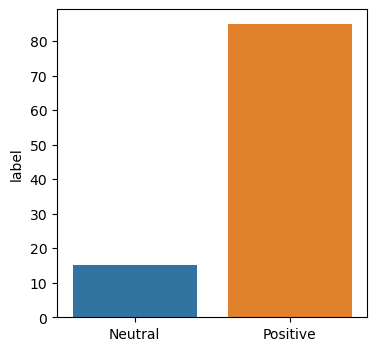

In [38]:
fig, ax = plt.subplots (figsize=(4, 4))
counts = positive_words_df.label.value_counts (normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels (['Neutral','Positive'])
plt.show()

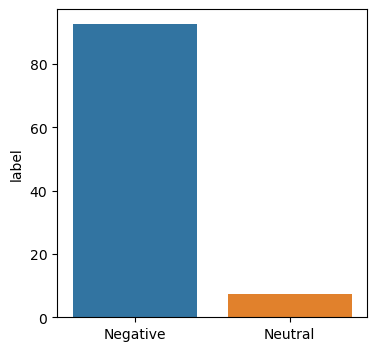

In [39]:
fig, ax = plt.subplots (figsize=(4, 4))
counts = negative_words_df.label.value_counts (normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels (['Negative','Neutral'])
plt.show()

In [41]:
positive_words= list(positive_words_df.loc[positive_words_df['label'] == 1].word) 
positive_words

['point',
 'stay',
 'anoth',
 'tri',
 'invis',
 'could',
 'suggest',
 'nope',
 'restart',
 'receiv',
 'say',
 'guess',
 'purchas',
 'award',
 'pack',
 'btw',
 'fault',
 'mess',
 'buy',
 'use',
 'thing',
 'funni',
 'request',
 'sent',
 'sinc',
 '25',
 '1600cp',
 'yet',
 'sure',
 '9999',
 'cant',
 'give',
 'cp',
 'word',
 'take',
 'away',
 'activis',
 'grant',
 'fix',
 'problem',
 'spent',
 'w',
 'transact',
 'gave',
 'proof',
 'got',
 'bp',
 '6',
 'keep',
 'dont',
 'imo',
 'wouldnt',
 'ridicul',
 'complet',
 'know',
 'im',
 'opinion',
 'compani',
 '1050',
 '1000',
 'though',
 'get',
 '2400',
 'one',
 'big',
 'deal',
 'ill',
 'play',
 'game',
 'intern',
 '950',
 'phone',
 'main',
 'account',
 'twitter',
 'facebook',
 'websit',
 'respons',
 '8',
 'day',
 'cod',
 'want',
 'go',
 'made',
 'work',
 'none',
 'noth',
 '100',
 'time',
 'limit',
 '14',
 'hour',
 'left',
 'still',
 'wait',
 'refund',
 'support',
 'gm',
 'right',
 'even',
 'manag',
 'knew',
 'free',
 'admit',
 'didnt',
 'well',
 '

In [42]:
positive_frequency = FreqDist (positive_words) 
pos_freq = positive_frequency.most_common (20) 
pos_freq

[('play', 140),
 ('game', 128),
 ('’', 109),
 ('get', 106),
 ('activis', 91),
 ('like', 83),
 ('ban', 82),
 ('account', 79),
 ('got', 77),
 ('support', 61),
 ('day', 59),
 ('even', 58),
 ('im', 53),
 ('good', 51),
 ('one', 48),
 ('never', 48),
 ('dont', 47),
 ('week', 47),
 ('issu', 46),
 ('still', 43)]

In [43]:
negative_words= list(negative_words_df.loc[negative_words_df['label'] == -1].word) 
negative_words

['keep',
 'ai',
 'use',
 'match',
 'futur',
 'game',
 'play',
 'across',
 'comput',
 'mani',
 'cheater',
 'ban',
 'train',
 '100',
 'zero',
 'scan',
 'give',
 'easi',
 'need',
 'spot',
 'program',
 'abl',
 'fine',
 'develop',
 'made',
 'massiv',
 'invest',
 'push',
 'law',
 'chang',
 'payout',
 'make',
 'movement',
 'organ',
 'record',
 'purchas',
 'said',
 'good',
 'end',
 'know',
 'clear',
 'step',
 'crimin',
 'take',
 'place',
 'id',
 'pretend',
 'dont',
 'bill',
 'anyon',
 '30000',
 'per',
 'hardwar',
 'beyond',
 'life',
 'around',
 'get',
 'tri',
 'cost',
 'go',
 'name',
 'real',
 'cheat',
 'stop',
 'time',
 'sold',
 'blacklist',
 '67',
 'outrag',
 'happi',
 'intellig',
 'video',
 'fals',
 'lie',
 'peopl',
 'correct',
 'forward',
 'info',
 'back',
 'track',
 'childish',
 'allow',
 'isnt',
 'secondari',
 'describ',
 'account',
 'sell',
 'user',
 'dear',
 'learn',
 'unlock',
 'alreadi',
 'wave',
 'fulli',
 'see',
 '33',
 'show',
 'pattern',
 'longer',
 'last',
 'year',
 'given',
 'f

In [44]:
negative_frequency = FreqDist (negative_words) 
neg_freq = negative_frequency.most_common (20) 
neg_freq

[('ban', 439),
 ('game', 309),
 ('get', 230),
 ('play', 227),
 ('got', 225),
 ('activis', 211),
 ('’', 193),
 ('account', 136),
 ('even', 123),
 ('shadow', 122),
 ('cheat', 121),
 ('day', 118),
 ('like', 115),
 ('time', 111),
 ('pc', 109),
 ('peopl', 97),
 ('softwar', 93),
 ('im', 92),
 ('report', 92),
 ('go', 91)]

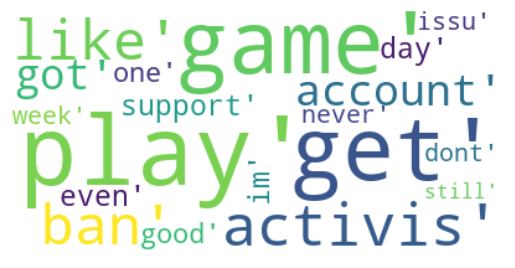

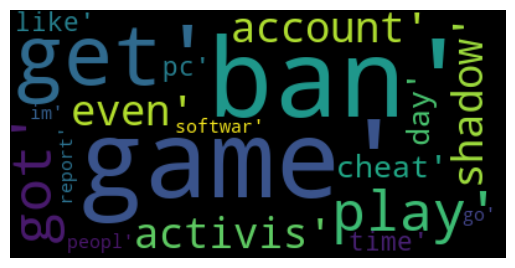

In [45]:
Pos_words = [str(p) for p in pos_freq] 
Pos_words_string= ','.join(Pos_words)
Neg_words = [str(n) for n in neg_freq] 
Neg_words_string=',' .join(Neg_words)
from wordcloud import WordCloud 
# Create and generate a word cloud image
wordcloud_positive = WordCloud (background_color='white').generate (Pos_words_string) 
wordcloud_negative = WordCloud ().generate (Neg_words_string)
# Display the generated image for Positive words plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis ("off")
plt.show()
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis ("off") 
plt.show()